In [1]:
import numpy as np
import pandas as pd
import time
import tracemalloc
import pathlib
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Flatten, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Input
from tensorflow.keras.models import Sequential
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers

import nltk
import re
import heapq

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB, ComplementNB, MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import gym
from baselines.ppo2 import ppo2
from baselines.ddpg import ddpg
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from baselines import deepq
from baselines import bench
from baselines import logger
from baselines.common.tf_util import make_session
from stable_baselines.deepq.policies import MlpPolicy, LnMlpPolicy
from stable_baselines import DQN

import matplotlib.pyplot as plt 
import pickle as pkl

import visualkeras
from PIL import ImageFont

c:\Users\Meesv\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\Meesv\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\Meesv\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\Meesv\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\f

c:\Users\Meesv\anaconda3\envs\myenv\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


# <font color='navy'>*1. Loading Dataset*

In [2]:
fakenewsnet = pd.read_csv('fakenewsnet.csv')

X = fakenewsnet[['text','real']]

X = X.dropna()

y = X[['real']]

X

,text,real
0,"When you visit the site, Dotdash Meredith and ...",True
1,Kylie Jenner reportedly doesn't want to talk a...,True
2,Character on American television series Scanda...,True
3,"From there, you transition to the leg press ma...",True
4,CNN —\n\nAn emotional Celine Dion returned to ...,True
...,...,...
20239,Thousands of government workers are unsure whe...,False
20240,During a time when the Republican Party’s pres...,False
20241,Completing the CAPTCHA proves you are a human ...,False
20242,"Yes, you can transfer your domain to any regis...",False


In [3]:
X['real'].value_counts()

True     12738
False     5068
Name: real, dtype: int64

# <font color='navy'>*2. Preprocessing*

In [4]:
count_vec = CountVectorizer()
ohe = count_vec.fit_transform((X['text']))
ohe = np.array(ohe.todense())

X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(ohe, y['real'], test_size=0.2, random_state=0)

In [5]:
ohe[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [6]:
X['text'][10]

'Bellamy Young may be riveting as First Lady Mellie Grant on ABC’s Scandal, but her off-screen story is just as captivating.\n\n“I was adopted, so I was in foster care for six weeks,” the actress, 45, says in the latest issue of PEOPLE. “We only had two lines on my dad and a paragraph on my mom. It said she loved to sing, so my mom who raised me would find any way to let me perform.”\n\nYoung says she spent her youth in Asheville, North Carolina, learning ballet and tap dancing and performing at school and church.\n\nAfter graduating from Yale, Young – who grew up with the first name Amy – spent a few years doing theater in New York before making the move to Los Angeles in 2000 to pursue TV and film work.\n\n“When I went to join the Screen Actors Guild, there was already an Amy Young so I had to register under a different name,” says Young. “I tried to become Susanna or Violet or something fabulous, but it just didn’t feel like I could carry the ruse off.”\n\nSo the actress turned to h

# <font color='navy'>*3. Defining functions*

### <font color='coral'>*3.1 Evaluation*

In [7]:
def confusion_matrix_disp(model_type, preds, y_test, cmap=plt.cm.Blues):
    plt.figure(1)
    conf_matr = confusion_matrix(y_test, preds)
    y_label_names = y_test.unique()
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matr, display_labels=y_label_names)
    disp.plot(cmap=cmap, xticks_rotation="vertical")
    disp.ax_.set_title(("Confusion Matrix " + model_type)) 

def draw_diagnostic(model_type, history):
    plt.figure(1)
    plt.title('Loss of ' + model_type)
    plt.plot(history['loss'], color='red', label='train')
    plt.plot(history['val_loss'], color='blue', label='test')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(['training', 'validation'])

    plt.figure(2)
    plt.title('Accuracy of ' + model_type)
    plt.plot(history['acc'], color='red', label='train')
    plt.plot(history['val_acc'], color='blue', label='test')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(['training', 'validation'])

    plt.show()

### <font color='coral'>*3.2 Convolutional Neural Network*

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 107359, 64)        11305856  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 107359, 64)        28736     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 53679, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 3435456)           0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 3435457   
Total params: 14,770,049
Trainable params: 14,770,049
Non-trainable params: 0
_________________________________________________________________


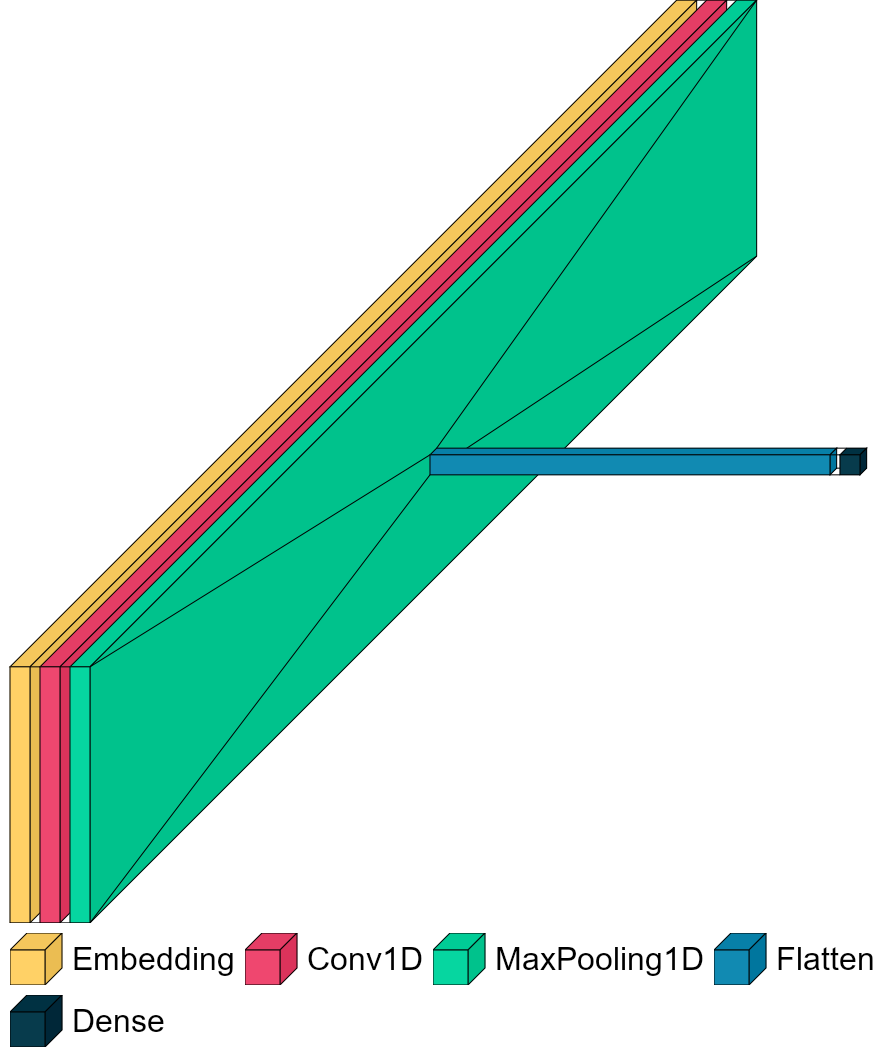

In [53]:
batch_size = 32
epochs = 5
loss='binary_crossentropy'
optimizer='adam'
vocab_length_ohe = 176654
max_seq_length_ohe = 107359

def cnn_model(vocab_length, max_seq_length, input_dim = X_train_ohe.shape[1], activation = 'sigmoid'):
    embedding_dim = 64
   
    cnn = Sequential()

    cnn.add(Embedding(vocab_length, embedding_dim,  input_length=max_seq_length))

    cnn.add(Conv1D(64 , 7, activation='relu', padding='same'))

    cnn.add(MaxPooling1D(2))

    cnn.add(Flatten())

    cnn.add(Dense(1, activation='sigmoid'))

    cnn.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    
    cnn.summary()
    return cnn

cnn = cnn_model(vocab_length_ohe,max_seq_length_ohe)
visualkeras.layered_view(cnn, legend=True, font=ImageFont.truetype("arial.ttf", 32))

In [9]:
class FakeNewsNetEnv_ohe(gym.Env,):
    def __init__(self, text_per_episode=1, dataset=(X_train_ohe, np.array(y_train_ohe)), random=True):
        super().__init__()

        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Box(low=0, high=1,
                                                shape=X_train_ohe[0].shape,
                                                dtype=np.float32)

        self.text_per_episode = text_per_episode
        self.step_count = 0

        self.x, self.y = dataset
        self.random = random
        self.dataset_idx = 0

    def step(self, action):
        done = False
        reward = int(action == self.expected_action)

        obs = self._next_obs()

        self.step_count += 1
        if self.step_count >= self.text_per_episode:
            done = True

        return obs, reward, done, {}

    def reset(self):
        self.step_count = 0

        obs = self._next_obs()
        return obs

    def _next_obs(self):
        if self.random:
            next_obs_idx = random.randint(0, len(self.x) - 1)
            self.expected_action = int(self.y[next_obs_idx])
            obs = self.x[next_obs_idx]

        else:
            obs = self.x[self.dataset_idx]
            self.expected_action = int(self.y[self.dataset_idx])

            self.dataset_idx += 1
            if self.dataset_idx >= len(self.x):
                raise StopIteration()

        return obs

# <font color='navy'>*4. Machine Learning*

### <font color='coral'>*4.1 Initial model*

In [37]:
nb_ohe_initial = ComplementNB()

file_nb_ohe_initial = pathlib.Path("nb_ohe_initial.npy")
if not file_nb_ohe_initial.exists ():
    tracemalloc.start()
    start_time_nb_ohe = time.time()

    nb_ohe_initial.fit(X_train_ohe, y_train_ohe)

    training_time_nb_ohe = time.time() - start_time_nb_ohe
    current_nb_we, peak_nb_ohe = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    print("Training time: "+str(training_time_nb_ohe)+" seconds")
    print(f"Current memory usage is {current_nb_we / 10**6}MB; Peak was {peak_nb_ohe / 10**6}MB")
    current_nb_we, peak_nb_ohe = 0, 0

    np.save('nb_ohe_initial.npy',nb_ohe_initial)

Training time: 58.179396867752075 seconds
Current memory usage is 4.296436MB; Peak was 7.84606MB


In [38]:
nb_ohe_initial = np.load('nb_ohe_initial.npy', allow_pickle='TRUE').item()

In [39]:
preds_nb_ohe_initial = nb_ohe_initial.predict(X_test_ohe)
print('accuracy: '+str(accuracy_score(preds_nb_ohe_initial, y_test_ohe)))

accuracy: 0.7695115103874228


### <font color='coral'>*4.2 Hyperparameter Tuning*

In [55]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
fit_priors = [True, False]

trained_models_nb = {}

for alpha in alphas:
    for fit_prior in fit_priors:
            print(str(alpha)+','+str(fit_prior))
            model = ComplementNB(alpha=alpha, fit_prior=fit_prior)
            model.fit(X_train_ohe, y_train_ohe)
            preds_nb_ohe = model.predict(X_test_ohe)
            accuracy = accuracy_score(preds_nb_ohe, y_test_ohe)
            trained_models_nb[str(alpha)+','+str(fit_prior)] = accuracy

0.001,True
0.001,False
0.01,True
0.01,False
0.1,True
0.1,False
1,True
1,False
10,True
10,False
100,True
100,False
1000,True
1000,False


In [56]:
print("All models with different combinations of hyperparameters:", end="\n\n\n")
accuracies = {}
for model, accuracy in trained_models_nb.items():
    print(str(model)+':','acc = '+str(accuracy))
    accuracies[model] = accuracy

All models with different combinations of hyperparameters:


0.001,True: acc = 0.774564851207187
0.001,False: acc = 0.774564851207187
0.01,True: acc = 0.7711959573273441
0.01,False: acc = 0.7711959573273441
0.1,True: acc = 0.7616507580011229
0.1,False: acc = 0.7616507580011229
1,True: acc = 0.7695115103874228
1,False: acc = 0.7695115103874228
10,True: acc = 0.7622122403144301
10,False: acc = 0.7622122403144301
100,True: acc = 0.7063447501403706
100,False: acc = 0.7063447501403706
1000,True: acc = 0.706064008983717
1000,False: acc = 0.706064008983717


In [57]:
print("The model with the highest accuracy is:", end="\n\n")
print(max(accuracies.items(), key = lambda k : k[1]))

The model with the highest accuracy is:

('0.001,True', 0.774564851207187)


In [58]:
hyperparameters_nb = max(accuracies.items(), key = lambda k : k[1])[0].split(',')
hyperparameters_nb

np.save('hyperparameters_nb.npy',hyperparameters_nb)

In [19]:
hyperparameters_nb = np.load('hyperparameters_nb.npy', allow_pickle='TRUE')

In [23]:
alpha_nb = float(hyperparameters_nb[0])
fit_prior_nb = bool(hyperparameters_nb[1])

In [46]:
hyperparameters_nb = max(accuracies.items(), key = lambda k : k[1])[0].split(',')
hyperparameters_nb

np.save('hyperparameters_nb.npy',hyperparameters_nb)

In [47]:
hyperparameters_nb = np.load('hyperparameters_nb.npy', allow_pickle='TRUE')

In [48]:
alpha_nb = float(hyperparameters_nb[0])
fit_prior_nb = bool(hyperparameters_nb[1])

### <font color='coral'>*4.3 Definitive model*

In [49]:
model_nb = ComplementNB(alpha=alpha_nb, fit_prior=fit_prior_nb)

file_nb_ohe = pathlib.Path("nb_ohe.npy")
if not file_nb_ohe.exists ():
    tracemalloc.start()
    start_time_nb_ohe = time.time()

    model_nb.fit(X_train_ohe, y_train_ohe)

    training_time_nb_ohe = time.time() - start_time_nb_ohe
    current_nb_we, peak_nb_ohe = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    print("Training time: "+str(training_time_nb_ohe)+" seconds")
    print(f"Current memory usage is {current_nb_we / 10**6}MB; Peak was {peak_nb_ohe / 10**6}MB")
    current_nb_we, peak_nb_ohe = 0, 0

    np.save('nb_ohe.npy',model_nb)

Training time: 34.67273950576782 seconds
Current memory usage is 4.443924MB; Peak was 7.993548MB


#### <font color='coral'>*4.3.1 Evaluation*

In [50]:
preds_nb_ohe = model_nb.predict(X_test_ohe)

<Figure size 640x480 with 0 Axes>

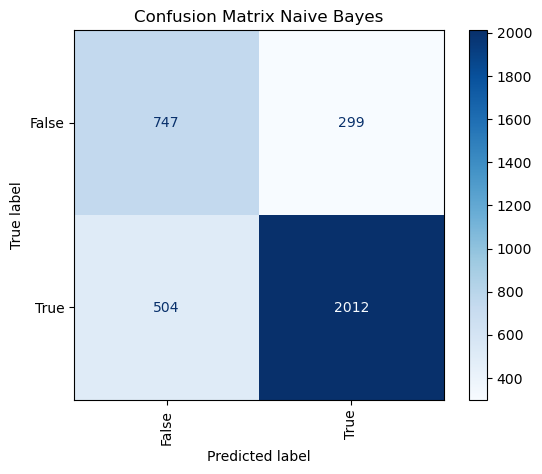

In [51]:
confusion_matrix_disp("Naive Bayes", preds_nb_ohe, y_test_ohe)

In [52]:
print("Classification report Naive Bayes")
print(classification_report(y_test_ohe, preds_nb_ohe))
print('accuracy: '+str(accuracy_score(preds_nb_ohe, y_test_ohe)))

Classification report Naive Bayes with One-Hot Encoding
              precision    recall  f1-score   support

       False       0.60      0.71      0.65      1046
        True       0.87      0.80      0.83      2516

    accuracy                           0.77      3562
   macro avg       0.73      0.76      0.74      3562
weighted avg       0.79      0.77      0.78      3562

accuracy: 0.774564851207187


# <font color='navy'>*5. Deep Learning*

### <font color='coral'>*5.1 Initial model*

In [10]:
vocab_length_ohe = 176654
max_seq_length_ohe = 107359

cnn_ohe_initial = cnn_model(vocab_length_ohe,max_seq_length_ohe)

file_cnn_ohe_initial = pathlib.Path("cnn_ohe_initial.h5")
if not file_cnn_ohe_initial.exists ():
    tracemalloc.start()
    start_time_cnn_ohe = time.time()

    history_cnn_ohe_initial = cnn_ohe_initial.fit(X_train_ohe, y_train_ohe, validation_split=0.2, batch_size=batch_size, epochs=epochs)

    training_time_cnn_ohe = time.time() - start_time_cnn_ohe
    current_cnn_ohe, peak_cnn_ohe = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    print("Training time: "+str(training_time_cnn_ohe)+" seconds")
    print(f"Current memory usage is {current_cnn_ohe / 10**6}MB; Peak was {peak_cnn_ohe / 10**6}MB")

    current_cnn_ohe, peak_cnn_ohe = 0, 0

    cnn_ohe_initial.save("cnn_ohe_initial.h5")

    history_cnn_ohe_initial = history_cnn_ohe_initial.history
    np.save('history_cnn_ohe_initial.npy',history_cnn_ohe_initial)

In [11]:
cnn_ohe_initial = tf.keras.models.load_model("cnn_ohe_initial.h5")

history_cnn_ohe_initial = np.load('history_cnn_ohe_initial.npy', allow_pickle='TRUE').item()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
preds_cnn_ohe_initial = (cnn_ohe_initial.predict(X_test_ohe) > 0.5).astype("int32")
print('accuracy: '+str(accuracy_score(preds_cnn_ohe_initial, y_test_ohe)))

accuracy: 0.8242560359348681


### <font color='coral'>*5.2 Hyperparameter Tuning*

In [15]:
losses = ['binary_crossentropy']
optimizers = ['rmsprop', 'adam']
epochs = [5, 10, 20]
batch_sizes = [64, 128]
activations = ['relu','sigmoid']

trained_models_cnn = {}

for loss in losses:
    for optimizer in optimizers:
        for epoch in epochs:
            for batch_size in batch_sizes:
                for activation in activations:
                    print(str(loss)+','+str(optimizer)+','+str(epoch)+','+str(batch_size)+','+str(activation))
                    model = cnn_model(vocab_length_ohe,max_seq_length_ohe, activation=activation)
                    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
                    history = model.fit(X_train_ohe, y_train_ohe, validation_split=0.2, epochs=epoch, batch_size=batch_size)
                    trained_models_cnn[str(loss)+','+str(optimizer)+','+str(epoch)+','+str(batch_size)+','+str(activation)] = history

binary_crossentropy,rmsprop,5,64,relu
Train on 11395 samples, validate on 2849 samples
Epoch 1/5
11395/11395 [==============================] - 26s 2ms/sample - loss: 1.3107 - acc: 0.7042 - val_loss: 1.4441 - val_acc: 0.7838
Epoch 2/5
11395/11395 [==============================] - 10s 903us/sample - loss: 1.0619 - acc: 0.8191 - val_loss: 1.2433 - val_acc: 0.7985
Epoch 3/5
11395/11395 [==============================] - 12s 1ms/sample - loss: 0.9563 - acc: 0.8631 - val_loss: 1.4023 - val_acc: 0.8185
Epoch 4/5
11395/11395 [==============================] - 9s 832us/sample - loss: 0.9204 - acc: 0.8887 - val_loss: 1.5251 - val_acc: 0.8192
Epoch 5/5
11395/11395 [==============================] - 10s 876us/sample - loss: 0.8461 - acc: 0.9097 - val_loss: 1.4610 - val_acc: 0.8098
binary_crossentropy,rmsprop,5,64,sigmoid
Train on 11395 samples, validate on 2849 samples
Epoch 1/5
11395/11395 [==============================] - 10s 895us/sample - loss: 0.5344 - acc: 0.7862 - val_loss: 0.5554 - val_

In [16]:
print("All models with different combinations of hyperparameters:", end="\n\n\n")
accuracies = {}
for model, history in trained_models_cnn.items():
    print(str(model)+':','acc = '+str(history.history['acc'][0]),'loss = '+str(history.history['loss'][0]))
    accuracies[model] = history.history['acc'][0]

All models with different combinations of hyperparameters:


binary_crossentropy,rmsprop,5,64,relu: acc = 0.7041685 loss = 1.310653672693277
binary_crossentropy,rmsprop,5,64,sigmoid: acc = 0.78622204 loss = 0.5344496959419092
binary_crossentropy,rmsprop,5,128,relu: acc = 0.7102238 loss = 1.6210763339569507
binary_crossentropy,rmsprop,5,128,sigmoid: acc = 0.77727073 loss = 0.5392677955273841
binary_crossentropy,rmsprop,10,64,relu: acc = 0.6767003 loss = 2.438486913695258
binary_crossentropy,rmsprop,10,64,sigmoid: acc = 0.7992979 loss = 0.5273280823313128
binary_crossentropy,rmsprop,10,128,relu: acc = 0.7119789 loss = 1.4162283308414996
binary_crossentropy,rmsprop,10,128,sigmoid: acc = 0.7749013 loss = 0.5451256470284791
binary_crossentropy,rmsprop,20,64,relu: acc = 0.7450636 loss = 1.529224556662917
binary_crossentropy,rmsprop,20,64,sigmoid: acc = 0.7987714 loss = 0.5312922155925086
binary_crossentropy,rmsprop,20,128,relu: acc = 0.6988153 loss = 1.440461957302989
binary_crossentropy,rms

In [17]:
print("The model with the highest accuracy is:", end="\n\n")
print(max(accuracies.items(), key = lambda k : k[1]))

The model with the highest accuracy is:

('binary_crossentropy,adam,20,128,sigmoid', 0.81044316)


In [18]:
hyperparameters_cnn = max(accuracies.items(), key = lambda k : k[1])[0].split(',')
hyperparameters_cnn

['binary_crossentropy', 'adam', '20', '128', 'sigmoid']

In [19]:
np.save('hyperparameters_cnn.npy',hyperparameters_cnn)


In [20]:
hyperparameters_cnn = np.load('hyperparameters_cnn.npy', allow_pickle='TRUE')

In [24]:
loss_cnn = hyperparameters_cnn[0]
optimizer_cnn = hyperparameters_cnn[1]
epochs_cnn = int(hyperparameters_cnn[2])
batch_size_cnn = int(hyperparameters_cnn[3])
activation_cnn = hyperparameters_cnn[4]

### <font color='coral'>*5.3 Definitive model*

In [21]:
vocab_length_ohe = 176654
max_seq_length_ohe = 107359

cnn_ohe = cnn_model(vocab_length_ohe,max_seq_length_ohe, activation=activation_cnn)

file_cnn_ohe = pathlib.Path("cnn_ohe.h5")
if not file_cnn_ohe.exists ():
    tracemalloc.start()
    start_time_cnn_ohe = time.time()
    cnn.compile(loss=loss_cnn, optimizer=optimizer_cnn, metrics=['accuracy'])
    history_cnn_ohe = cnn_ohe.fit(X_train_ohe, y_train_ohe, validation_split=0.2, batch_size=batch_size_cnn, epochs=epochs_cnn)

    training_time_cnn_ohe = time.time() - start_time_cnn_ohe
    current_cnn_ohe, peak_cnn_ohe = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    print("Training time: "+str(training_time_cnn_ohe)+" seconds")
    print(f"Current memory usage is {current_cnn_ohe / 10**6}MB; Peak was {peak_cnn_ohe / 10**6}MB")

    current_cnn_ohe, peak_cnn_ohe = 0, 0

    cnn_ohe.save("cnn_ohe.h5")

    history_cnn_ohe = history_cnn_ohe.history
    np.save('history_cnn_ohe.npy',history_cnn_ohe)

Train on 11395 samples, validate on 2849 samples
Epoch 1/20
11395/11395 [==============================] - 8s 669us/sample - loss: 0.5619 - acc: 0.7450 - val_loss: 0.5080 - val_acc: 0.8210
Epoch 2/20
11395/11395 [==============================] - 7s 625us/sample - loss: 0.3965 - acc: 0.8591 - val_loss: 0.4649 - val_acc: 0.8403
Epoch 3/20
11395/11395 [==============================] - 8s 665us/sample - loss: 0.2865 - acc: 0.9023 - val_loss: 0.4741 - val_acc: 0.8399
Epoch 4/20
11395/11395 [==============================] - 8s 672us/sample - loss: 0.2162 - acc: 0.9314 - val_loss: 0.5209 - val_acc: 0.8347
Epoch 5/20
11395/11395 [==============================] - 8s 662us/sample - loss: 0.1688 - acc: 0.9469 - val_loss: 0.5806 - val_acc: 0.8354
Epoch 6/20
11395/11395 [==============================] - 7s 645us/sample - loss: 0.1392 - acc: 0.9595 - val_loss: 0.5174 - val_acc: 0.8245
Epoch 7/20
11395/11395 [==============================] - 7s 596us/sample - loss: 0.1183 - acc: 0.9685 - val_lo

In [22]:
cnn_ohe = tf.keras.models.load_model("cnn_ohe.h5")

history_cnn_ohe = np.load('history_cnn_ohe.npy', allow_pickle='TRUE').item()

#### <font color='coral'>*5.3.1 Evaluation*

In [23]:
preds_cnn_ohe = (cnn_ohe.predict(X_test_ohe) > 0.5).astype("int32")

<Figure size 640x480 with 0 Axes>

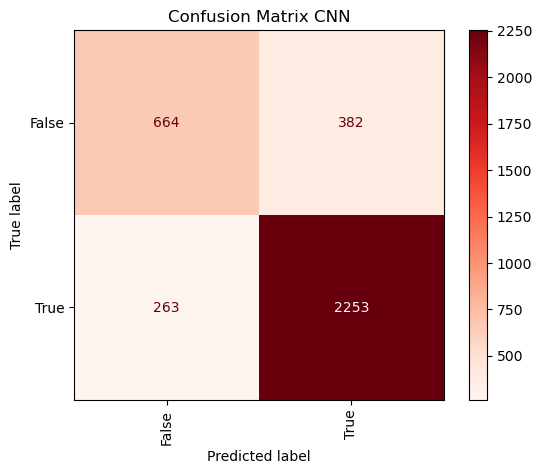

In [24]:
confusion_matrix_disp("CNN", preds_cnn_ohe, y_test_ohe, cmap=plt.cm.Reds)

In [25]:
print("Classification report CNN")
print(classification_report(y_test_ohe, preds_cnn_ohe))
print('accuracy: '+str(accuracy_score(preds_cnn_ohe, y_test_ohe)))

Classification report CNN
              precision    recall  f1-score   support

       False       0.72      0.63      0.67      1046
        True       0.86      0.90      0.87      2516

    accuracy                           0.82      3562
   macro avg       0.79      0.77      0.77      3562
weighted avg       0.81      0.82      0.82      3562

accuracy: 0.8189219539584504


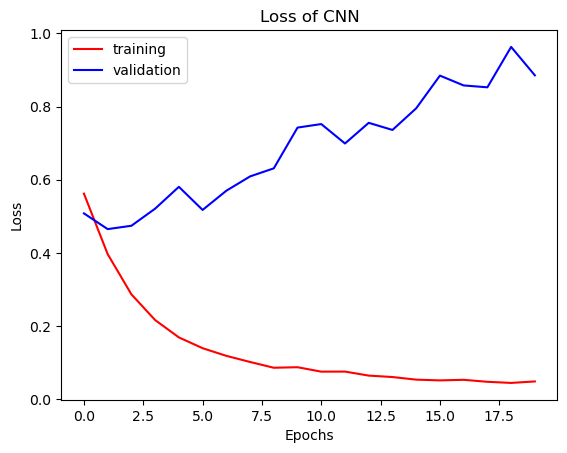

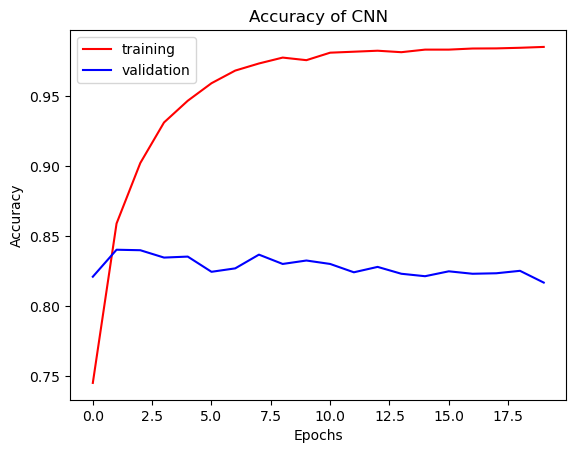

In [26]:
draw_diagnostic("CNN", history_cnn_ohe)

# <font color='navy'>*6. Deep Reinforcement Learning*

### <font color='coral'>*6.1 Initial model*

In [27]:
logger.configure(dir='./logs/dqn_ohe_initial', format_strs=['stdout', 'tensorboard'])
env = FakeNewsNetEnv_ohe(text_per_episode=1)
env = bench.Monitor(env, logger.get_dir())

dqn_ohe_initial = DQN(MlpPolicy, env, verbose=2, learning_rate=0.0001, batch_size=32)

tracemalloc.start()
start_time_dqn_ohe_initial = time.time()
dqn_ohe_initial.learn(total_timesteps = len(X_train_ohe)//2)
print("DQN Training Time:", time.time() - start_time_dqn_ohe_initial)
current_dqn_ohe_initial, peak_dqn_ohe_initial = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f"Current memory usage is {current_dqn_ohe_initial / 10**6}MB; Peak was {peak_dqn_ohe_initial / 10**6}MB")
current_dqn_ohe_initial, peak_dqn_ohe_initial = 0, 0
dqn_ohe_initial.save('dqn_ohe_initial.npy')
env.close()

Logging to ./logs/dqn_ohe_initial





Instructions for updating:
Use keras.layers.flatten instead.


--------------------------------------
| % time spent exploring  | 86       |
| episodes                | 100      |
| mean 100 episode reward | 0.5      |
| steps                   | 99       |
--------------------------------------
--------------------------------------
| % time spent exploring  | 72       |
| episodes                | 200      |
| mean 100 episode reward | 0.5      |
| steps                   | 199      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 58       |
| episodes                | 300      |
| mean 100 episode reward | 0.4      |
| steps                   | 299      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 45       |
| episodes                | 400      |
| mean 100 episode reward | 0.5      |
| steps                   | 399      |
-

In [28]:
preds_dqn_ohe_initial = dqn_ohe_initial.predict(X_test_ohe)[0]
print('accuracy: '+str(accuracy_score(preds_dqn_ohe_initial, y_test_ohe)))

accuracy: 0.8183604716451431


### <font color='coral'>*6.2 Hyperparameter Tuning*

In [34]:
policies = [MlpPolicy]
learning_rates = [0.0001, 0.01,100]
batch_sizes = [128]
total_timesteps = [len(X_train_ohe)//2, len(X_train_ohe), len(X_train_ohe)*2]

trained_models_dqn = {}

for policy in policies:
    for learning_rate in learning_rates:
        for batch_size in batch_sizes:
            for total_timestep in total_timesteps:
                print(str(policy)+','+str(learning_rate)+','+str(batch_size)+','+str(total_timestep))
                env = FakeNewsNetEnv_ohe(text_per_episode=1)
                model = DQN(policy, env, verbose=2, learning_rate=learning_rate, batch_size=batch_size)
                model.learn(total_timesteps = total_timestep)
                env.close()
                preds_dqn_ohe = model.predict(X_test_ohe)[0]
                accuracy = accuracy_score(preds_dqn_ohe, y_test_ohe)
                trained_models_dqn[str(policy)+','+str(learning_rate)+','+str(batch_size)+','+str(total_timestep)] = accuracy

<class 'stable_baselines.deepq.policies.MlpPolicy'>,0.0001,128,7122
--------------------------------------
| % time spent exploring  | 86       |
| episodes                | 100      |
| mean 100 episode reward | 0.4      |
| steps                   | 99       |
--------------------------------------
--------------------------------------
| % time spent exploring  | 72       |
| episodes                | 200      |
| mean 100 episode reward | 0.5      |
| steps                   | 199      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 58       |
| episodes                | 300      |
| mean 100 episode reward | 0.6      |
| steps                   | 299      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 45       |
| episodes                | 400      |
| mean 100 episode reward | 0.6      |
| steps                   | 399      |
-----------------------------------

In [35]:
print("All models with different combinations of hyperparameters:", end="\n\n\n")
accuracies = {}
for model, accuracy in trained_models_dqn.items():
    print(str(model)+':','acc = '+str(accuracy))
    accuracies[model] = accuracy

All models with different combinations of hyperparameters:


<class 'stable_baselines.deepq.policies.MlpPolicy'>,0.0001,128,7122: acc = 0.8239752947782145
<class 'stable_baselines.deepq.policies.MlpPolicy'>,0.0001,128,14244: acc = 0.823694553621561
<class 'stable_baselines.deepq.policies.MlpPolicy'>,0.0001,128,28488: acc = 0.8408197641774284
<class 'stable_baselines.deepq.policies.MlpPolicy'>,0.01,128,7122: acc = 0.8029197080291971
<class 'stable_baselines.deepq.policies.MlpPolicy'>,0.01,128,14244: acc = 0.7304884896125772
<class 'stable_baselines.deepq.policies.MlpPolicy'>,0.01,128,28488: acc = 0.813307130825379
<class 'stable_baselines.deepq.policies.MlpPolicy'>,100,128,7122: acc = 0.29421673217293653
<class 'stable_baselines.deepq.policies.MlpPolicy'>,100,128,14244: acc = 0.7063447501403706
<class 'stable_baselines.deepq.policies.MlpPolicy'>,100,128,28488: acc = 0.7063447501403706


In [36]:
print("The model with the highest accuracy is:", end="\n\n")
print(max(accuracies.items(), key = lambda k : k[1]))

The model with the highest accuracy is:

("<class 'stable_baselines.deepq.policies.MlpPolicy'>,0.0001,128,28488", 0.8408197641774284)


In [37]:
hyperparameters_dqn = max(accuracies.items(), key = lambda k : k[1])[0].split(',')
hyperparameters_dqn
np.save('hyperparameters_dqn.npy',hyperparameters_dqn)

In [21]:
hyperparameters_dqn = np.load('hyperparameters_dqn.npy', allow_pickle='TRUE')

In [25]:
policy_dqn = hyperparameters_dqn[0]
learning_rate_dqn = float(hyperparameters_dqn[1])
batch_size_dqn = int(hyperparameters_dqn[2])
total_timesteps_dqn = int(hyperparameters_dqn[3])

### <font color='coral'>*6.3 Definitive model*

In [44]:
logger.configure(dir='./logs/dqn_ohe', format_strs=['stdout', 'tensorboard'])
env = FakeNewsNetEnv_ohe(text_per_episode=1)
env = bench.Monitor(env, logger.get_dir())

dqn_ohe = DQN(MlpPolicy, env, verbose=2, learning_rate=learning_rate_dqn, batch_size=batch_size_dqn)

tracemalloc.start()
start_time_dqn_ohe = time.time()
dqn_ohe.learn(total_timesteps = total_timesteps_dqn)
print("DQN Training Time:", time.time() - start_time_dqn_ohe)
current_dqn_ohe, peak_dqn_ohe = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f"Current memory usage is {current_dqn_ohe / 10**6}MB; Peak was {peak_dqn_ohe / 10**6}MB")
current_dqn_ohe, peak_dqn_ohe = 0, 0
dqn_ohe.save('dqn_ohe.npy')
env.close()

Logging to ./logs/dqn_ohe
--------------------------------------
| % time spent exploring  | 96       |
| episodes                | 100      |
| mean 100 episode reward | 0.5      |
| steps                   | 99       |
--------------------------------------
--------------------------------------
| % time spent exploring  | 93       |
| episodes                | 200      |
| mean 100 episode reward | 0.5      |
| steps                   | 199      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 89       |
| episodes                | 300      |
| mean 100 episode reward | 0.5      |
| steps                   | 299      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 86       |
| episodes                | 400      |
| mean 100 episode reward | 0.4      |
| steps                   | 399      |
--------------------------------------
--------------------------------------

#### <font color='coral'>*6.3.1 Evaluation*

In [45]:
preds_dqn_ohe = dqn_ohe.predict(X_test_ohe)[0]

In [46]:
print("Classification report DQN")
print(classification_report(y_test_ohe, preds_dqn_ohe))
print('accuracy: '+str(accuracy_score(preds_dqn_ohe, y_test_ohe)))

Classification report DQN
              precision    recall  f1-score   support

       False       0.77      0.61      0.68      1046
        True       0.85      0.92      0.89      2516

    accuracy                           0.83      3562
   macro avg       0.81      0.77      0.78      3562
weighted avg       0.83      0.83      0.82      3562

accuracy: 0.8309938236945537


<Figure size 640x480 with 0 Axes>

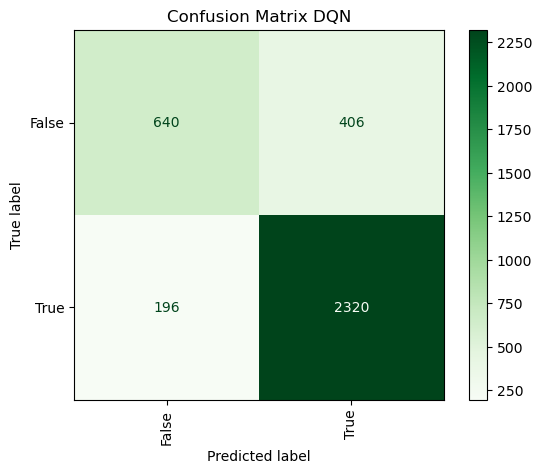

In [47]:
confusion_matrix_disp("DQN", preds_dqn_ohe, y_test_ohe, cmap=plt.cm.Greens)

In [48]:
# !tensorboard dev upload --logdir "C:\Users\Meesv\OneDrive\Tilburg University\Master\Master Thesis\2 Thesis\Code\logs"

# <font color='navy'>*7. Dimensionality reduction*

### <font color='coral'>*7.1 Text Summarization*

In [49]:

def text_summarizer(text):
    sentence_list = nltk.sent_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')

    word_frequencies = {}
    for word in nltk.word_tokenize(text):
        if word not in stopwords:
            if word not in word_frequencies.keys():
                word_frequencies[word] = 1
            else:
                word_frequencies[word] += 1
    maximum_frequncy = max(word_frequencies.values())

    for word in word_frequencies.keys():
        word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)
    sentence_scores = {}
    for sent in sentence_list:
        for word in nltk.word_tokenize(sent.lower()):
            if word in word_frequencies.keys():
                if len(sent.split(' ')) < 30:
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = word_frequencies[word]
                    else:
                        sentence_scores[sent] += word_frequencies[word]
    
    summary_sentences = heapq.nlargest(7, sentence_scores, key=sentence_scores.get)
    summary = ' '.join(summary_sentences)
    return summary


In [50]:
file_summarized_text = pathlib.Path("text_summarized.pkl")
if not file_summarized_text.exists ():
    summaries = X['text'].apply(text_summarizer)
    summaries.to_pickle("text_summarized.pkl")
    summaries

In [51]:
summaries = pd.read_pickle("text_summarized.pkl")

summaries

0        When you visit the site, Dotdash Meredith and ...
1        'When the show was announced in April, the net...
2        [1]\n\nBackground [ edit ]\n\nShe lived in Cal...
3        From there, you transition to the leg press ma...
4        For you, it’s, ‘Do we still go to Celine’s sho...
                               ...                        
20239    The Food and Drug Administration, however, wil...
20240    I just can’t.”\n\nDonald Trump claimed that Ju...
20241    If you are at an office or shared network, you...
20242    Since domain transfers are a manual process, i...
20243    Contact your hosting provider for more informa...
Name: text, Length: 17806, dtype: object

In [52]:
count_vec = CountVectorizer()
ohe_sum = count_vec.fit_transform(summaries)
ohe_sum = np.array(ohe_sum.todense())

X_train_ohe_sum, X_test_ohe_sum, y_train_ohe_sum, y_test_ohe_sum = train_test_split(ohe_sum, y['real'], test_size=0.2, random_state=0)

#### <font color='coral'>*7.1.1 Machine Learning*

In [61]:
nb_ohe_sum = ComplementNB(alpha=alpha_nb, fit_prior=fit_prior_nb)

file_nb_ohe_sum = pathlib.Path("nb_ohe_sum.npy")
if not file_nb_ohe_sum.exists ():
    tracemalloc.start()
    start_time_ohe_sum = time.time()

    nb_ohe_sum.fit(X_train_ohe_sum, y_train_ohe_sum)

    training_time_ohe_sum = time.time() - start_time_ohe_sum
    current_ohe_sum, peak_ohe_sum = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    print("Training time: "+str(training_time_ohe_sum)+" seconds")
    print(f"Current memory usage is {current_ohe_sum / 10**6}MB; Peak was {peak_ohe_sum / 10**6}MB")
    current_ohe_sum, peak_ohe_sum = 0, 0

    np.save('nb_ohe_sum.npy', nb_ohe_sum)

Training time: 18.951168298721313 seconds
Current memory usage is 2.021956MB; Peak was 3.752372MB


In [62]:
nb_ohe_sum = np.load('nb_ohe_sum.npy', allow_pickle='TRUE').item()

In [63]:
preds_nb_ohe_sum = nb_ohe_sum.predict(X_test_ohe_sum)

<Figure size 640x480 with 0 Axes>

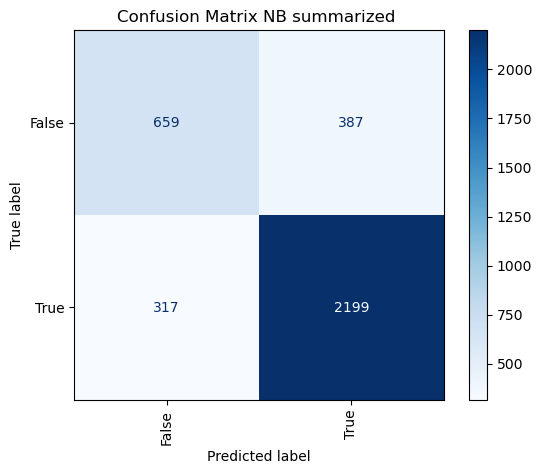

In [64]:
confusion_matrix_disp("NB summarized ", preds_nb_ohe_sum, y_test_ohe_sum)

In [65]:
print("Classification report CNN summarized")
print(classification_report(y_test_ohe_sum, preds_nb_ohe_sum))
print('accuracy: '+str(accuracy_score(preds_nb_ohe_sum, y_test_ohe_sum)))

Classification report CNN summarized
              precision    recall  f1-score   support

       False       0.68      0.63      0.65      1046
        True       0.85      0.87      0.86      2516

    accuracy                           0.80      3562
   macro avg       0.76      0.75      0.76      3562
weighted avg       0.80      0.80      0.80      3562

accuracy: 0.80235822571589


#### <font color='coral'>*7.1.2 Deep Learning*

In [66]:
vocab_length_ohe_sum = 176654
max_seq_length_ohe_sum = 107359

cnn_ohe_sum = cnn_model(vocab_length_ohe_sum,max_seq_length_ohe_sum, input_dim = X_train_ohe_sum.shape[1], activation=activation_cnn)

file_cnn_ohe_sum = pathlib.Path("cnn_ohe_sum.h5")
if not file_cnn_ohe_sum.exists ():
    tracemalloc.start()
    start_time_cnn_ohe_sum = time.time()
    cnn_ohe_sum.compile(loss=loss_cnn, optimizer=optimizer_cnn, metrics=['accuracy'])
    history_cnn_ohe_sum = cnn_ohe_sum.fit(X_train_ohe_sum, y_train_ohe_sum, validation_split=0.2, batch_size=batch_size_cnn, epochs=epochs_cnn)

    training_time_cnn_ohe_sum = time.time() - start_time_cnn_ohe_sum
    current_cnn_ohe_sum, peak_cnn_ohe_sum = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    print("Training time: "+str(training_time_cnn_ohe_sum)+" seconds")
    print(f"Current memory usage is {current_cnn_ohe_sum / 10**6}MB; Peak was {peak_cnn_ohe_sum / 10**6}MB")

    current_cnn_ohe_sum, peak_cnn_ohe_sum = 0, 0

    cnn_ohe_sum.save("cnn_ohe_sum.h5")

    history_cnn_ohe_sum = history_cnn_ohe_sum.history
    np.save('history_cnn_ohe_sum.npy',history_cnn_ohe_sum)

Train on 11395 samples, validate on 2849 samples
Epoch 1/20
11395/11395 [==============================] - 4s 382us/sample - loss: 0.5156 - acc: 0.7759 - val_loss: 0.4542 - val_acc: 0.8168
Epoch 2/20
11395/11395 [==============================] - 4s 309us/sample - loss: 0.3588 - acc: 0.8576 - val_loss: 0.4233 - val_acc: 0.8284
Epoch 3/20
11395/11395 [==============================] - 3s 303us/sample - loss: 0.2691 - acc: 0.9043 - val_loss: 0.4250 - val_acc: 0.8291
Epoch 4/20
11395/11395 [==============================] - 4s 316us/sample - loss: 0.2063 - acc: 0.9323 - val_loss: 0.4361 - val_acc: 0.8206
Epoch 5/20
11395/11395 [==============================] - 3s 307us/sample - loss: 0.1622 - acc: 0.9501 - val_loss: 0.4597 - val_acc: 0.8263
Epoch 6/20
11395/11395 [==============================] - 4s 311us/sample - loss: 0.1319 - acc: 0.9619 - val_loss: 0.4798 - val_acc: 0.8245
Epoch 7/20
11395/11395 [==============================] - 4s 310us/sample - loss: 0.1087 - acc: 0.9704 - val_lo

In [67]:
cnn_ohe_sum = tf.keras.models.load_model("cnn_ohe_sum.h5")

history_cnn_ohe_sum = np.load('history_cnn_ohe_sum.npy', allow_pickle='TRUE').item()

In [68]:
preds_cnn_ohe_sum = (cnn_ohe_sum.predict(X_test_ohe_sum) > 0.5).astype("int32")

<Figure size 640x480 with 0 Axes>

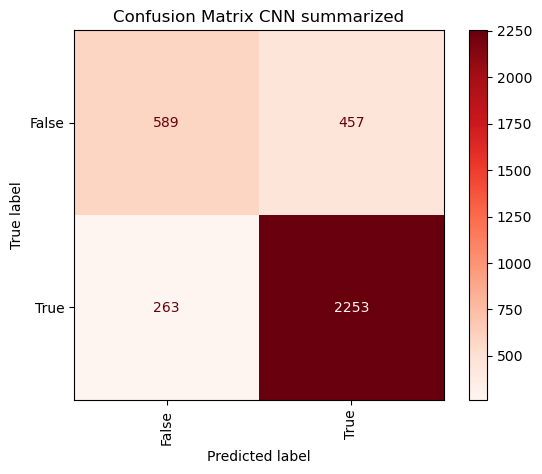

In [69]:
confusion_matrix_disp("CNN summarized", preds_cnn_ohe_sum, y_test_ohe_sum, cmap=plt.cm.Reds)

In [70]:
print("Classification report CNN summarized")
print(classification_report(y_test_ohe_sum, preds_cnn_ohe_sum))
print('accuracy: '+str(accuracy_score(preds_cnn_ohe_sum, y_test_ohe_sum)))

Classification report CNN summarized
              precision    recall  f1-score   support

       False       0.69      0.56      0.62      1046
        True       0.83      0.90      0.86      2516

    accuracy                           0.80      3562
   macro avg       0.76      0.73      0.74      3562
weighted avg       0.79      0.80      0.79      3562

accuracy: 0.7978663672094329


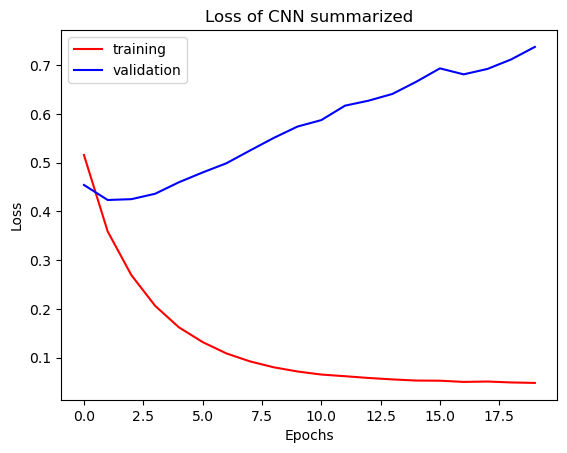

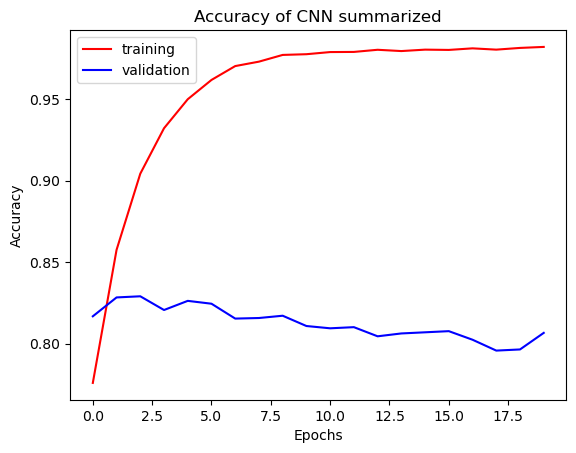

In [71]:
draw_diagnostic("CNN summarized", history_cnn_ohe_sum)

#### <font color='coral'>*7.1.3 Deep Reinforcement Learning*

In [72]:
class FakeNewsNetEnv_ohe_sum(gym.Env,):
    def __init__(self, text_per_episode=1, dataset=(X_train_ohe_sum, np.array(y_train_ohe_sum)), random=True):
        super().__init__()

        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Box(low=0, high=1,
                                                shape=X_train_ohe_sum[0].shape,
                                                dtype=np.float32)

        self.text_per_episode = text_per_episode
        self.step_count = 0

        self.x, self.y = dataset
        self.random = random
        self.dataset_idx = 0

    def step(self, action):
        done = False
        reward = int(action == self.expected_action)

        obs = self._next_obs()

        self.step_count += 1
        if self.step_count >= self.text_per_episode:
            done = True

        return obs, reward, done, {}

    def reset(self):
        self.step_count = 0

        obs = self._next_obs()
        return obs

    def _next_obs(self):
        if self.random:
            next_obs_idx = random.randint(0, len(self.x) - 1)
            self.expected_action = int(self.y[next_obs_idx])
            obs = self.x[next_obs_idx]

        else:
            obs = self.x[self.dataset_idx]
            self.expected_action = int(self.y[self.dataset_idx])

            self.dataset_idx += 1
            if self.dataset_idx >= len(self.x):
                raise StopIteration()

        return obs

In [73]:
logger.configure(dir='./logs/dqn_ohe_sum', format_strs=['stdout', 'tensorboard'])
env = FakeNewsNetEnv_ohe_sum(text_per_episode=1)
env = bench.Monitor(env, logger.get_dir())

dqn_ohe_sum = DQN(MlpPolicy, env, verbose = 2, learning_rate = learning_rate_dqn, batch_size = batch_size_dqn)

tracemalloc.start()
start_time_ohe_sum = time.time()
dqn_ohe_sum.learn(total_timesteps = total_timesteps_dqn)
print("DQN_we Training Time:", time.time() - start_time_ohe_sum)
current_dqn_ohe_sum, peak_dqn_ohe_sum = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f"Current memory usage is {current_dqn_ohe_sum / 10**6}MB; Peak was {peak_dqn_ohe_sum / 10**6}MB")
current_dqn_ohe_sum, peak_dqn_ohe_sum = 0, 0

dqn_ohe_sum.save('dqn_ohe_sum.npy')
env.close()

Logging to ./logs/dqn_ohe_sum
--------------------------------------
| % time spent exploring  | 96       |
| episodes                | 100      |
| mean 100 episode reward | 0.5      |
| steps                   | 99       |
--------------------------------------
--------------------------------------
| % time spent exploring  | 93       |
| episodes                | 200      |
| mean 100 episode reward | 0.6      |
| steps                   | 199      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 89       |
| episodes                | 300      |
| mean 100 episode reward | 0.6      |
| steps                   | 299      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 86       |
| episodes                | 400      |
| mean 100 episode reward | 0.5      |
| steps                   | 399      |
--------------------------------------
----------------------------------

In [74]:
preds_dqn_ohe_sum = dqn_ohe_sum.predict(X_test_ohe_sum)[0]

In [75]:
print("Classification report DQN summarized")
print(classification_report(y_test_ohe_sum, preds_dqn_ohe_sum))
print('accuracy: '+str(accuracy_score(preds_dqn_ohe_sum, y_test_ohe_sum)))

Classification report DQN summarized
              precision    recall  f1-score   support

       False       0.73      0.57      0.64      1046
        True       0.84      0.91      0.87      2516

    accuracy                           0.81      3562
   macro avg       0.79      0.74      0.76      3562
weighted avg       0.81      0.81      0.81      3562

accuracy: 0.813307130825379


<Figure size 640x480 with 0 Axes>

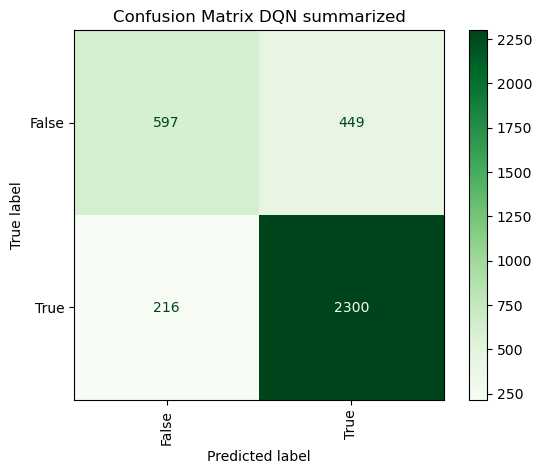

In [76]:
confusion_matrix_disp("DQN summarized", preds_dqn_ohe_sum, y_test_ohe_sum, cmap=plt.cm.Greens)

### <font color='coral'>*7.2 Subset*

In [17]:
count_vec = CountVectorizer()
ohe_sub = count_vec.fit_transform((X['text']))
ohe_sub = np.array(ohe_sub.todense())

X_train_ohe_sub, null , y_train_ohe_sub, null = train_test_split(ohe_sub, y['real'], test_size=0.9, random_state=0)

null, X_test_ohe_sub , null, y_test_ohe_sub = train_test_split(ohe_sub, y['real'], test_size=0.2, random_state=0)

#### <font color='coral'>*7.2.1 Machine Learning*

In [26]:
nb_ohe_sub = ComplementNB(alpha=alpha_nb, fit_prior=fit_prior_nb)

file_nb_ohe_sub = pathlib.Path("nb_ohe_sub.npy")
if not file_nb_ohe_sub.exists ():
    tracemalloc.start()
    start_time_ohe_sub = time.time()

    nb_ohe_sub.fit(X_train_ohe_sub, y_train_ohe_sub)

    training_time_ohe_sub = time.time() - start_time_ohe_sub
    current_ohe_sub, peak_ohe_sub = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    print("Training time: "+str(training_time_ohe_sub)+" seconds")
    print(f"Current memory usage is {current_ohe_sub / 10**6}MB; Peak was {peak_ohe_sub / 10**6}MB")
    current_ohe_sub, peak_ohe_sub = 0, 0

    np.save('nb_ohe_sub.npy', nb_ohe_sub)

Training time: 3.541414499282837 seconds
Current memory usage is 4.471843MB; Peak was 7.921171MB


In [27]:
nb_ohe_sub = np.load('nb_ohe_sub.npy', allow_pickle='TRUE').item()

In [28]:
preds_nb_ohe_sub = nb_ohe_sub.predict(X_test_ohe_sub)

<Figure size 640x480 with 0 Axes>

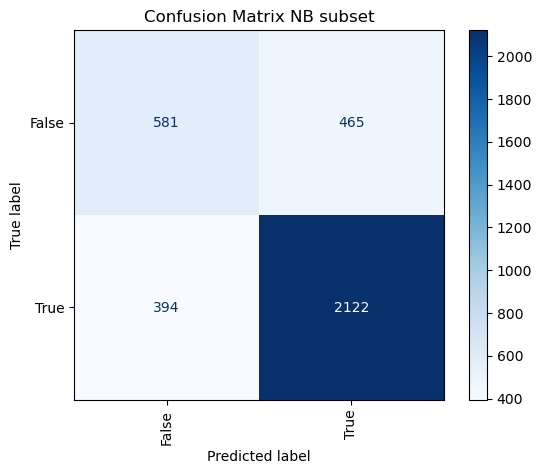

In [29]:
confusion_matrix_disp("NB subset", preds_nb_ohe_sub, y_test_ohe_sub)

In [30]:
print("Classification report CNN subset ")
print(classification_report(y_test_ohe_sub, preds_nb_ohe_sub))
print('accuracy: '+str(accuracy_score(preds_nb_ohe_sub, y_test_ohe_sub)))

Classification report CNN subset 
              precision    recall  f1-score   support

       False       0.60      0.56      0.57      1046
        True       0.82      0.84      0.83      2516

    accuracy                           0.76      3562
   macro avg       0.71      0.70      0.70      3562
weighted avg       0.75      0.76      0.76      3562

accuracy: 0.7588433464345873


#### <font color='coral'>*7.2.2 Deep Learning*

In [40]:
vocab_length_ohe_sub = 176654
max_seq_length_ohe_sub = 107359

cnn_ohe_sub = cnn_model(vocab_length_ohe_sub,max_seq_length_ohe_sub, input_dim = X_train_ohe_sub.shape[1], activation = activation_cnn)

file_cnn_ohe_sub = pathlib.Path("cnn_ohe_sub.h5")
if not file_cnn_ohe_sub.exists ():
    tracemalloc.start()
    start_time_cnn_ohe_sub = time.time()
    cnn_ohe_sub.compile(loss=loss_cnn, optimizer=optimizer_cnn, metrics=['accuracy'])
    history_cnn_ohe_sub = cnn_ohe_sub.fit(X_train_ohe_sub, y_train_ohe_sub, validation_split=0.2, batch_size=batch_size_cnn, epochs=epochs_cnn)

    training_time_cnn_ohe_sub = time.time() - start_time_cnn_ohe_sub
    current_cnn_ohe_sub, peak_cnn_ohe_sub = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    print("Training time: "+str(training_time_cnn_ohe_sub)+" seconds")
    print(f"Current memory usage is {current_cnn_ohe_sub / 10**6}MB; Peak was {peak_cnn_ohe_sub / 10**6}MB")

    current_cnn_ohe_sub, peak_cnn_ohe_sub = 0, 0

    cnn_ohe_sub.save("cnn_ohe_sub.h5")

    history_cnn_ohe_sub = history_cnn_ohe_sub.history
    np.save('history_cnn_ohe_sub.npy',history_cnn_ohe_sub)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1)                 107360    
Total params: 107,360
Trainable params: 107,360
Non-trainable params: 0
_________________________________________________________________
Train on 1424 samples, validate on 356 samples
Epoch 1/20
1424/1424 [==============================] - 1s 775us/sample - loss: 0.6765 - acc: 0.7079 - val_loss: 0.6468 - val_acc: 0.7247
Epoch 2/20
1424/1424 [==============================] - 1s 588us/sample - loss: 0.5047 - acc: 0.8631 - val_loss: 0.6926 - val_acc: 0.7079
Epoch 3/20
1424/1424 [==============================] - 1s 590us/sample - loss: 0.4303 - acc: 0.8336 - val_loss: 0.6516 - val_acc: 0.7612
Epoch 4/20
1424/1424 [==============================] - 1s 588us/sample - loss: 0.3820 - acc: 0.9333 - val_loss: 0.6684 - val_acc: 0.7556
Epoch 5/20
1424/1424 [====================

In [ ]:
cnn_ohe_sub = tf.keras.models.load_model("cnn_ohe_sub.h5")

history_cnn_ohe_sub = np.load('history_cnn_ohe_sub.npy', allow_pickle='TRUE').item()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [42]:
preds_cnn_ohe_sub = (cnn_ohe_sub.predict(X_test_ohe_sub) > 0.5).astype("int32")

<Figure size 640x480 with 0 Axes>

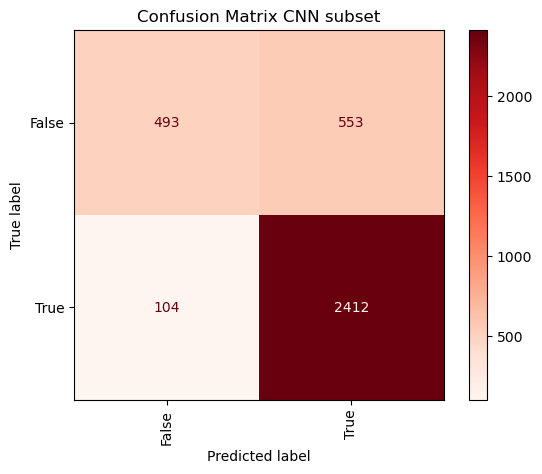

In [43]:
confusion_matrix_disp("CNN subset", preds_cnn_ohe_sub, y_test_ohe_sub, cmap=plt.cm.Reds)

In [44]:
print("Classification report CNN subset")
print(classification_report(y_test_ohe_sub, preds_cnn_ohe_sub))
print('accuracy: '+str(accuracy_score(preds_cnn_ohe_sub, y_test_ohe_sub)))

Classification report CNN subset
              precision    recall  f1-score   support

       False       0.83      0.47      0.60      1046
        True       0.81      0.96      0.88      2516

    accuracy                           0.82      3562
   macro avg       0.82      0.71      0.74      3562
weighted avg       0.82      0.82      0.80      3562

accuracy: 0.8155530600786075


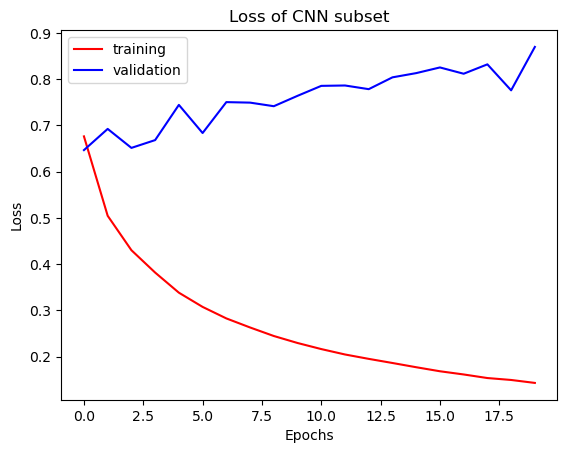

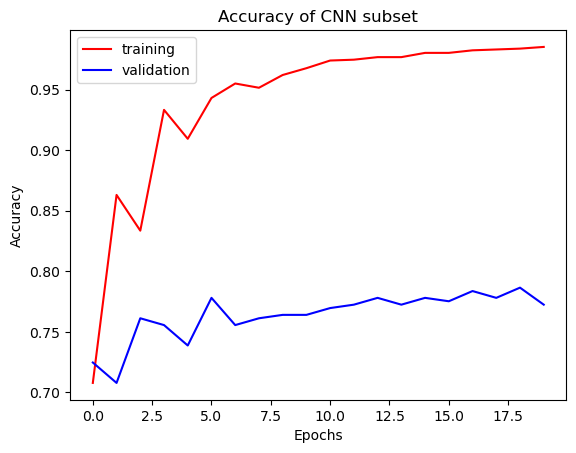

In [54]:
draw_diagnostic("CNN subset", history_cnn_ohe_sub)

#### <font color='coral'>*7.2.3 Deep Reinforcement Learning*

In [46]:
class FakeNewsNetEnv_ohe_sub(gym.Env,):
    def __init__(self, text_per_episode=1, dataset=(X_train_ohe_sub, np.array(y_train_ohe_sub)), random=True):
        super().__init__()

        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Box(low=0, high=1,
                                                shape=X_train_ohe_sub[0].shape,
                                                dtype=np.float32)

        self.text_per_episode = text_per_episode
        self.step_count = 0

        self.x, self.y = dataset
        self.random = random
        self.dataset_idx = 0

    def step(self, action):
        done = False
        reward = int(action == self.expected_action)

        obs = self._next_obs()

        self.step_count += 1
        if self.step_count >= self.text_per_episode:
            done = True

        return obs, reward, done, {}

    def reset(self):
        self.step_count = 0

        obs = self._next_obs()
        return obs

    def _next_obs(self):
        if self.random:
            next_obs_idx = random.randint(0, len(self.x) - 1)
            self.expected_action = int(self.y[next_obs_idx])
            obs = self.x[next_obs_idx]

        else:
            obs = self.x[self.dataset_idx]
            self.expected_action = int(self.y[self.dataset_idx])

            self.dataset_idx += 1
            if self.dataset_idx >= len(self.x):
                raise StopIteration()

        return obs

In [47]:
logger.configure(dir='./logs/dqn_ohe_sub', format_strs=['stdout', 'tensorboard'])
env = FakeNewsNetEnv_ohe_sub(text_per_episode=1)
env = bench.Monitor(env, logger.get_dir())

dqn_ohe_sub = DQN(MlpPolicy, env, verbose = 2, learning_rate = learning_rate_dqn, batch_size = batch_size_dqn)

tracemalloc.start()
start_time_ohe_sub = time.time()
dqn_ohe_sub.learn(total_timesteps = total_timesteps_dqn)
print("DQN_we Training Time:", time.time() - start_time_ohe_sub)
current_dqn_ohe_sub, peak_dqn_ohe_sub = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f"Current memory usage is {current_dqn_ohe_sub / 10**6}MB; Peak was {peak_dqn_ohe_sub / 10**6}MB")
current_dqn_ohe_sub, peak_dqn_ohe_sub = 0, 0

dqn_ohe_sub.save('dqn_ohe_sub.pkl')
env.close()

Logging to ./logs/dqn_ohe_sub





Instructions for updating:
Use keras.layers.flatten instead.


--------------------------------------
| % time spent exploring  | 96       |
| episodes                | 100      |
| mean 100 episode reward | 0.5      |
| steps                   | 99       |
--------------------------------------
--------------------------------------
| % time spent exploring  | 93       |
| episodes                | 200      |
| mean 100 episode reward | 0.5      |
| steps                   | 199      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 89       |
| episodes                | 300      |
| mean 100 episode reward | 0.4      |
| steps                   | 299      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 86       |
| episodes                | 400      |
| mean 100 episode reward | 0.5      |
| steps                   | 399      |
-----

In [48]:
preds_dqn_ohe_sub = dqn_ohe_sub.predict(X_test_ohe_sub)[0]

In [49]:
print("Classification report DQN subset")
print(classification_report(y_test_ohe_sub, preds_dqn_ohe_sub))
print('accuracy: '+str(accuracy_score(preds_dqn_ohe_sub, y_test_ohe_sub)))

Classification report DQN subset
              precision    recall  f1-score   support

       False       0.77      0.48      0.59      1046
        True       0.81      0.94      0.87      2516

    accuracy                           0.81      3562
   macro avg       0.79      0.71      0.73      3562
weighted avg       0.80      0.81      0.79      3562

accuracy: 0.8065693430656934


<Figure size 640x480 with 0 Axes>

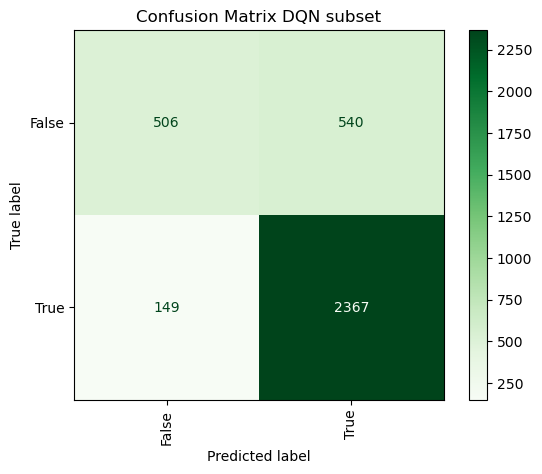

In [50]:
confusion_matrix_disp("DQN subset", preds_dqn_ohe_sub, y_test_ohe_sub, cmap=plt.cm.Greens)

In [51]:
# !tensorboard dev upload --logdir "C:\Users\Meesv\OneDrive\Tilburg University\Master\Master Thesis\2 Thesis\Code\DEF-New-New\logs"